El modelo implementado corresponde a un detector de objetos de dos etapas, inspirado en la arquitectura Faster R-CNN, pero desarrollado completamente desde cero, sin utilizar modelos preentrenados, librerías de detección externas ni arquitecturas estandarizadas.
-
---

1. Backbone (Extracción de Características)

La primera parte del modelo es una red convolucional ligera llamada EspaldaCNN.
Su función es extraer un mapa de características a partir de la imagen de entrada.
Esta red reduce la resolución de la imagen y codifica información relevante para la detección, sin depender de arquitecturas externas como ResNet o MobileNet.

2. Generación de Anchors

Sobre el mapa de características generado se construyen anchors:
cajas base de diferentes escalas y proporciones ubicadas en cada celda del feature map.

Cada anchor representa una hipótesis inicial de posible objeto.
El conjunto de anchors constituye la base para la primera etapa del detector.

3. RPN (Region Proposal Network)

La RPN evalúa cada anchor y produce dos resultados:

Objectness → probabilidad de que el anchor contenga un objeto.

BBox Deltas → ajustes para mover el anchor hacia la posición correcta.

La RPN tiene:

- una convolución compartida de 3×3,

- una cabeza de clasificación,

- una cabeza de regresión.

Esto permite generar propuestas iniciales de regiones que podrían contener objetos.

4. Decodificación y Filtrado de Propuestas

Los deltas predichos se aplican a los anchors para obtener cajas refinadas.
Luego se ejecuta un proceso de Non-Maximum Suppression (NMS) que elimina propuestas muy solapadas y conserva únicamente las mejor puntuadas.

El resultado es un conjunto reducido de propuestas de regiones (RoIs) para la segunda etapa.

5. ROI Align

Cada propuesta generada se proyecta sobre el mapa de características original mediante ROI Align, una operación que extrae regiones de tamaño fijo sin perder información espacial.

Esto prepara cada región candidata para la clasificación final.

6. ROI Head (Segunda Etapa del Detector)

Las regiones extraídas por ROI Align alimentan un ROI Head compuesto por dos capas totalmente conectadas.

La salida del ROI Head incluye:

- Logits de clasificación (una clase por objeto),

- Deltas finales de bounding box refinados para cada clase.

- Esta segunda etapa completa la detección final por objeto.

7. Funciones de Pérdida

Durante el entrenamiento se combinan varias pérdidas:

- BCEWithLogitsLoss para el objectness de la RPN.

- SmoothL1Loss para los deltas de regresión (RPN y ROI).

- CrossEntropyLoss para la clasificación del ROI Head.

Estas pérdidas permiten que el modelo aprenda tanto la localización como la clasificación de los objetos.

8. Métricas de Evaluación

En cada época se calculan métricas basadas en IoU ≥ 0.5:

- TP (True Positives)

- FP (False Positives)

- FN (False Negatives)

- Precision

- Recall

- Accuracy

- F1-Score

Estas métricas permiten evaluar el desempeño de detección del modelo.

MONTADO DE DRIVE Y PREPARACION DE ENTORNO
-

In [ ]:
from __future__ import annotations

from google.colab import drive
import os

drive.mount('/content/drive')

RUTA_BASE = "/content/drive/MyDrive/IA2/final"

RUTA_DATASET_ZIP = f"{RUTA_BASE}/data.zip"

RUTA_DATASET = "/content/data"

RUTA_CHECKPOINTS = f"{RUTA_BASE}/checkpoints"
os.makedirs(RUTA_CHECKPOINTS, exist_ok=True)

print("  Dataset ZIP:", RUTA_DATASET_ZIP)
print("  Carpeta de dataset descomprimido:", RUTA_DATASET)
print("  Carpeta de checkpoints:", RUTA_CHECKPOINTS)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado correctamente.
Rutas configuradas:
  • Dataset ZIP: /content/drive/MyDrive/IA2/final/data.zip
  • Carpeta de dataset descomprimido: /content/data
  • Carpeta de checkpoints: /content/drive/MyDrive/IA2/final/checkpoints


Descomprimir el dataset desde ZIP
-

In [ ]:
import os
import zipfile
import shutil

if os.path.exists(RUTA_DATASET):
    shutil.rmtree(RUTA_DATASET)

os.makedirs(RUTA_DATASET, exist_ok=True)

if not os.path.exists(RUTA_DATASET_ZIP):
    raise FileNotFoundError(
        f"ERROR: No se encontró el archivo ZIP en {RUTA_DATASET_ZIP}"
    )

with zipfile.ZipFile(RUTA_DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(RUTA_DATASET)

print("Dataset listo en:", RUTA_DATASET)

Descomprimiendo dataset...
Dataset descomprimido en: /content/data


DIVISION TRAIN/VAL/TEST 80/10/10
-

In [ ]:
import json, os, random, shutil

RUTA_COCO = f"{RUTA_DATASET}/data/detector.json"
RUTA_IMGS = f"{RUTA_DATASET}/data/images"
RUTA_SPLIT = "/content/split"

TRAIN_IMG = f"{RUTA_SPLIT}/train/images"
VAL_IMG   = f"{RUTA_SPLIT}/val/images"
TEST_IMG  = f"{RUTA_SPLIT}/test/images"

TRAIN_JSON = f"{RUTA_SPLIT}/train.json"
VAL_JSON   = f"{RUTA_SPLIT}/val.json"
TEST_JSON  = f"{RUTA_SPLIT}/test.json"

if os.path.exists(RUTA_SPLIT):
    shutil.rmtree(RUTA_SPLIT)

os.makedirs(TRAIN_IMG, exist_ok=True)
os.makedirs(VAL_IMG, exist_ok=True)
os.makedirs(TEST_IMG, exist_ok=True)


with open(RUTA_COCO, "r") as f:
    coco = json.load(f)

imagenes = coco["images"]
anotaciones = coco["annotations"]
categorias = coco["categories"]

random.shuffle(imagenes)

n = len(imagenes)
n_train = int(0.70 * n)
n_val   = int(0.20 * n)
n_test  = n - n_train - n_val

train_imgs = imagenes[:n_train]
val_imgs   = imagenes[n_train : n_train + n_val]
test_imgs  = imagenes[n_train + n_val :]

ids_train = {img["id"] for img in train_imgs}
ids_val   = {img["id"] for img in val_imgs}
ids_test  = {img["id"] for img in test_imgs}

def filtrar_anotaciones(ids):
    return [a for a in anotaciones if a["image_id"] in ids]

coco_train = {"images": train_imgs, "annotations": filtrar_anotaciones(ids_train), "categories": categorias}
coco_val   = {"images": val_imgs,   "annotations": filtrar_anotaciones(ids_val),   "categories": categorias}
coco_test  = {"images": test_imgs,  "annotations": filtrar_anotaciones(ids_test),  "categories": categorias}

with open(TRAIN_JSON, "w") as f: json.dump(coco_train, f, indent=2)
with open(VAL_JSON,   "w") as f: json.dump(coco_val,   f, indent=2)
with open(TEST_JSON,  "w") as f: json.dump(coco_test,  f, indent=2)

def copiar(lista, destino):
    for img in lista:
        nombre = img["file_name"]
        shutil.copy(f"{RUTA_IMGS}/{nombre}", destino)

copiar(train_imgs, TRAIN_IMG)
copiar(val_imgs,   VAL_IMG)
copiar(test_imgs,  TEST_IMG)

print("Train:", len(train_imgs))
print("Val:", len(val_imgs))
print("Test:", len(test_imgs))

Cargando COCO...
Copiando imágenes...

✔ División completada
Train: 14000
Val: 4000
Test: 2000


TRANSFORMACIONES Y DATALOADER
-

In [32]:
import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

augment_basic = T.Compose([
    T.ColorJitter(brightness=0.30, contrast=0.30, saturation=0.30),
    T.RandomGrayscale(p=0.10),
    T.GaussianBlur(kernel_size=3),
    T.RandomAutocontrast(p=0.10),
    T.RandomEqualize(p=0.05),
])

transform_resize = T.Resize((300, 300))
transform_to_tensor = T.ToTensor()

transform_train = T.Compose([
    transform_resize,
    transform_to_tensor,
])

transform_eval = T.Compose([
    transform_resize,
    transform_to_tensor,
])

class DatasetCOCO(Dataset):
    def __init__(self, ruta_json, ruta_imagenes, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.ruta_imagenes = ruta_imagenes

        with open(ruta_json, "r") as f:
            coco = json.load(f)

        self.imagenes = coco["images"]
        self.anot = coco["annotations"]
        self.categorias = coco["categories"]

        self.map_imagen_anot = {}
        for a in self.anot:
            img_id = a["image_id"]
            if img_id not in self.map_imagen_anot:
                self.map_imagen_anot[img_id] = []
            self.map_imagen_anot[img_id].append(a)

    def __len__(self):
        return len(self.imagenes)

    def __getitem__(self, idx):
        info = self.imagenes[idx]
        img_id = info["id"]
        nombre = info["file_name"]

        img_path = os.path.join(self.ruta_imagenes, nombre)
        img = Image.open(img_path).convert("RGB")

        if self.augment:
            img = augment_basic(img)

        anotaciones = self.map_imagen_anot.get(img_id, [])

        cajas = []
        labels = []

        for a in anotaciones:
            x, y, w, h = a["bbox"]
            cajas.append([x, y, x+w, y+h])
            labels.append(a["category_id"])

        if len(cajas) == 0:
            cajas = torch.zeros((0,4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            cajas = torch.tensor(cajas, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            img = self.transform(img)

        return img, {"boxes": cajas, "labels": labels}

def collate_fn(batch):
    imgs = []
    tgts = []
    for img, tgt in batch:
        imgs.append(img)
        tgts.append(tgt)
    return imgs, tgts

def crear_loader(json_path=None, img_path=None, bs=2, shuffle=True, transform=None, augment=False, **kwargs):
    if json_path is None and "ruta_json" in kwargs:
        json_path = kwargs["ruta_json"]
    if img_path is None and "ruta_imagenes" in kwargs:
        img_path = kwargs["ruta_imagenes"]
    if bs is None and "batch_size" in kwargs:
        bs = kwargs["batch_size"]

    dataset = DatasetCOCO(
        ruta_json=json_path,
        ruta_imagenes=img_path,
        transform=transform,
        augment=augment
    )

    return DataLoader(
        dataset,
        batch_size=bs,
        shuffle=shuffle,
        num_workers=0,
        collate_fn=collate_fn
    )

print("DataLoader con augmentation")

✔ DataLoader con augmentation SEGURO habilitado.


BACKBONE
-

In [33]:
import torch.nn as nn

class EspaldaCNN(nn.Module):
    def __init__(self, canales_salida=256):
        super().__init__()
        self.bloque1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=4, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.bloque2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.bloque3 = nn.Sequential(
            nn.Conv2d(128, canales_salida, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(canales_salida),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.bloque1(x)
        x = self.bloque2(x)
        x = self.bloque3(x)
        return x

print("Backbone lito")

✔ Backbone cargada correctamente.


GENERADOR DE ANCLAS
-

In [34]:
import math
import torch

def generar_anclas_para_mapa(
    alto_fm,
    ancho_fm,
    stride,
    escalas=[64, 128, 256],
    razones=[0.5, 1.0, 2.0],
    dispositivo="cpu"
):
    anclas = []

    for i in range(alto_fm):
        for j in range(ancho_fm):
            cx = (j + 0.5) * stride
            cy = (i + 0.5) * stride

            for escala in escalas:
                for razon in razones:
                    area = escala * escala
                    w = math.sqrt(area * razon)
                    h = area / w

                    x1 = cx - w / 2
                    y1 = cy - h / 2
                    x2 = cx + w / 2
                    y2 = cy + h / 2

                    anclas.append([x1, y1, x2, y2])

    return torch.tensor(anclas, dtype=torch.float32, device=dispositivo)

RPN
-

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class RPNCabezal(nn.Module):
    def __init__(self, canales_entrada, num_anclas):
        super().__init__()

        self.conv = nn.Conv2d(canales_entrada, canales_entrada, kernel_size=3, padding=1)
        self.logits = nn.Conv2d(canales_entrada, num_anclas, kernel_size=1)
        self.regresion = nn.Conv2d(canales_entrada, num_anclas * 4, kernel_size=1)

        for capa in [self.conv, self.logits, self.regresion]:
            nn.init.normal_(capa.weight, std=0.01)
            if capa.bias is not None:
                nn.init.constant_(capa.bias, 0)

    def forward(self, caracteristicas):
        t = F.relu(self.conv(caracteristicas))

        logits = self.logits(t)
        bboxs = self.regresion(t)

        B, A, H, W = logits.shape

        objectness = logits.permute(0, 2, 3, 1).reshape(B, -1)
        bboxs = bboxs.permute(0, 2, 3, 1).reshape(B, -1, 4)

        return objectness, bboxs

DECODIFICADOR DE PROPUESTA
-

In [36]:
import torch
from torchvision.ops import nms

def aplicar_deltas_a_anclas(anclas, deltas):
    widths  = anclas[:, 2] - anclas[:, 0]
    heights = anclas[:, 3] - anclas[:, 1]
    ctr_x   = anclas[:, 0] + 0.5 * widths
    ctr_y   = anclas[:, 1] + 0.5 * heights

    dx = deltas[:, 0]
    dy = deltas[:, 1]
    dw = deltas[:, 2]
    dh = deltas[:, 3]

    pred_ctr_x = dx * widths  + ctr_x
    pred_ctr_y = dy * heights + ctr_y
    pred_w  = torch.exp(dw) * widths
    pred_h  = torch.exp(dh) * heights

    x1 = pred_ctr_x - 0.5 * pred_w
    y1 = pred_ctr_y - 0.5 * pred_h
    x2 = pred_ctr_x + 0.5 * pred_w
    y2 = pred_ctr_y + 0.5 * pred_h

    return torch.stack([x1, y1, x2, y2], dim=1)

def filtrar_propuestas(propuestas, puntajes, pre_nms=300, post_nms=50, umbral_nms=0.5):
    puntajes_ordenados, idx = puntajes.sort(descending=True)
    if pre_nms is not None:
        idx = idx[:pre_nms]
    props = propuestas[idx]
    punts = puntajes_ordenados[:len(idx)]
    keep = nms(props, punts, umbral_nms)
    keep = keep[:post_nms]
    return props[keep], punts[keep]

ROI + CABEZERA
-

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import roi_align

class CabezalRoI(nn.Module):
    def __init__(self, canales_entrada, tamaño_roi=(7, 7), num_clases=5):
        super().__init__()
        self.tamaño_roi = tamaño_roi
        self.spatial_scale = 1.0 / 4.0
        self.num_clases = num_clases
        flatten_size = canales_entrada * tamaño_roi[0] * tamaño_roi[1]
        self.fc1 = nn.Linear(flatten_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_clases)
        self.bbox_pred = nn.Linear(1024, num_clases * 4)
        nn.init.normal_(self.fc1.weight, std=0.01)
        nn.init.normal_(self.fc2.weight, std=0.01)
        nn.init.normal_(self.cls_score.weight, std=0.01)
        nn.init.normal_(self.bbox_pred.weight, std=0.001)

    def forward(self, feature_map, propuestas, tamaños_imagen):
        device = feature_map.device
        rois = []
        for b, props in enumerate(propuestas):
            if props.shape[0] == 0:
                continue
            for p in props:
                rois.append([b, p[0].item(), p[1].item(), p[2].item(), p[3].item()])

        if len(rois) == 0:
            return None, None

        rois = torch.tensor(rois, dtype=torch.float32, device=device)

        pooled = roi_align(
            feature_map,
            rois,
            output_size=self.tamaño_roi,
            spatial_scale=self.spatial_scale,
            sampling_ratio=2
        )

        x = pooled.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        logits = self.cls_score(x)
        deltas = self.bbox_pred(x)

        return logits, deltas

DETECTOR DE DOS ETAPAS
-

In [38]:
import torch
import torch.nn as nn

class DetectorDosEtapas(nn.Module):
    def __init__(self, num_clases=5, canales_salida=256):
        super().__init__()
        self.num_clases = num_clases
        self.backbone = EspaldaCNN(canales_salida)
        self.escalas = [64, 128, 256]
        self.razones = [0.5, 1.0, 2.0]
        num_anclas = len(self.escalas) * len(self.razones)
        self.rpn = RPNCabezal(canales_entrada=canales_salida, num_anclas=num_anclas)
        self.roi_head = CabezalRoI(canales_salida, tamaño_roi=(7,7), num_clases=num_clases)

    def forward(self, imagenes, training=True):
        device = next(self.parameters()).device

        imagenes_dev = [img.to(device) for img in imagenes]
        batch = torch.stack(imagenes_dev)

        features = self.backbone(batch)
        B, C, Hf, Wf = features.shape
        stride = batch.shape[2] // Hf

        anchors = generar_anclas_para_mapa(
            Hf, Wf,
            stride=stride,
            escalas=self.escalas,
            razones=self.razones,
            dispositivo=device
        )

        objectness, deltas_rpn = self.rpn(features)

        propuestas_batch = []
        puntajes_batch = []

        for b in range(B):
            puntajes = objectness[b].sigmoid()
            deltas = deltas_rpn[b]
            propuestas = aplicar_deltas_a_anclas(anchors, deltas)

            propuestas[:, 0].clamp_(min=0, max=batch.shape[3])
            propuestas[:, 1].clamp_(min=0, max=batch.shape[2])
            propuestas[:, 2].clamp_(min=0, max=batch.shape[3])
            propuestas[:, 3].clamp_(min=0, max=batch.shape[2])

            props_filtradas, punts_filtrados = filtrar_propuestas(
                propuestas, puntajes, pre_nms=1000, post_nms=200, umbral_nms=0.7
            )

            propuestas_batch.append(props_filtradas)
            puntajes_batch.append(punts_filtrados)

        logits_roi, deltas_roi = self.roi_head(
            features,
            propuestas_batch,
            tamaños_imagen=[(batch.shape[2], batch.shape[3])] * B
        )

        return {
            "features": features,
            "anchors": anchors,
            "propuestas": propuestas_batch,
            "puntajes_propuestas": puntajes_batch,
            "logits_roi": logits_roi,
            "deltas_roi": deltas_roi
        }

print("Detector dos etapas listo")

✔ Detector dos etapas ensamblado correctamente.


ENTRENAMIENTO Y GUARDADO DE EPOCH
-

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Entrenando en:", device)

num_clases = 5
epochs = 40
batch_size = 2
lr = 1e-3

modelo = DetectorDosEtapas(num_clases=num_clases).to(device)

ultimo_ckpt = f"{RUTA_CHECKPOINTS}/ultimo.pth"
inicio_epoca = 1
if os.path.exists(ultimo_ckpt):
    modelo.load_state_dict(torch.load(ultimo_ckpt, map_location=device))
    with open(f"{RUTA_CHECKPOINTS}/epoch.txt", "r") as f:
        inicio_epoca = int(f.read()) + 1
    print(f"Reanudando desde epoch {inicio_epoca}")

opt = optim.Adam(modelo.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

bce = nn.BCEWithLogitsLoss()
smooth_l1 = nn.SmoothL1Loss(reduction="sum")
ce = nn.CrossEntropyLoss()

train_loader = crear_loader(
    json_path=f"{RUTA_SPLIT}/train.json",
    img_path=f"{RUTA_SPLIT}/train/images",
    bs=batch_size,
    shuffle=True,
    transform=transform_train,
    augment=True
)

val_loader = crear_loader(
    json_path=f"{RUTA_SPLIT}/val.json",
    img_path=f"{RUTA_SPLIT}/val/images",
    bs=batch_size,
    shuffle=False,
    transform=transform_eval,
    augment=False
)

def calcular_iou(a, b):
    N = a.size(0)
    M = b.size(0)
    if N == 0 or M == 0:
        return torch.zeros((N, M), device=a.device)

    x1 = torch.max(a[:, None, 0], b[:, 0])
    y1 = torch.max(a[:, None, 1], b[:, 1])
    x2 = torch.min(a[:, None, 2], b[:, 2])
    y2 = torch.min(a[:, None, 3], b[:, 3])

    inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    union = area_a[:, None] + area_b - inter
    return inter / union.clamp(min=1e-6)

for ep in range(inicio_epoca, epochs + 1):

    modelo.train()
    ep_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Época {ep}")

    for imagenes, targets in pbar:
        opt.zero_grad()

        salida = modelo(imagenes)
        anchors = salida["anchors"]
        propuestas = salida["propuestas"]
        logits_roi = salida["logits_roi"]
        deltas_roi = salida["deltas_roi"]

        loss = torch.tensor(0.0, device=device)

        features = modelo.backbone(torch.stack([img.to(device) for img in imagenes]))
        objectness_logits, _ = modelo.rpn(features)

        for b in range(len(imagenes)):
            gt_boxes = targets[b]["boxes"].to(device)
            if gt_boxes.numel() == 0:
                continue

            obj_logits = objectness_logits[b]
            iou = calcular_iou(anchors, gt_boxes)
            max_iou, _ = iou.max(dim=1)
            labels_pos = (max_iou >= 0.5).float()

            loss = loss + bce(obj_logits, labels_pos)

        if logits_roi is not None and deltas_roi is not None:

            props_cat = []
            img_idx = []

            for b_idx, props in enumerate(propuestas):
                for p in props:
                    props_cat.append(p.to(device))
                    img_idx.append(b_idx)

            if len(props_cat) > 0:
                props_cat = torch.stack(props_cat)
                img_idx = torch.tensor(img_idx, device=device)

                gt_labels_all = []
                gt_boxes_all = []

                for r in range(len(props_cat)):
                    b = img_idx[r].item()
                    gt_b = targets[b]["boxes"].to(device)
                    gt_l = targets[b]["labels"].to(device)

                    if gt_b.numel() == 0:
                        gt_labels_all.append(0)
                        gt_boxes_all.append(torch.zeros(4, device=device))
                        continue

                    iou_r = calcular_iou(props_cat[r:r+1], gt_b)
                    maxv, idx = iou_r.max(dim=1)

                    if maxv >= 0.5:
                        cls = int(gt_l[idx])
                        gt_labels_all.append(cls)

                        box = gt_b[idx]
                        if box.dim() == 2:
                            box = box.squeeze(0)
                        gt_boxes_all.append(box)
                    else:
                        gt_labels_all.append(0)
                        gt_boxes_all.append(torch.zeros(4, device=device))

                gt_labels_all = torch.tensor(gt_labels_all, dtype=torch.long, device=device)
                gt_boxes_all = torch.stack(gt_boxes_all)

                loss = loss + ce(logits_roi, gt_labels_all)
                loss = loss + smooth_l1(deltas_roi[:, :4], gt_boxes_all)

        loss.backward()
        nn.utils.clip_grad_norm_(modelo.parameters(), max_norm=5.0)
        opt.step()

        ep_loss += loss.item()
        pbar.set_postfix({"loss": ep_loss})

    modelo.eval()
    TP = FP = FN = 0

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = [img.to(device) for img in imgs]
            out = modelo(imgs)
            props_b = out["propuestas"]

            for b in range(len(imgs)):
                gt_boxes = targets[b]["boxes"].to(device)
                props = props_b[b]

                if gt_boxes.numel() == 0:
                    continue
                if props is None or props.numel() == 0:
                    FN += len(gt_boxes)
                    continue

                iou = calcular_iou(props, gt_boxes)

                for g in range(len(gt_boxes)):
                    if iou[:, g].max() >= 0.5:
                        TP += 1
                    else:
                        FN += 1

                for p in range(len(props)):
                    if iou[p].max() < 0.5:
                        FP += 1

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = TP / (TP + FP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    print(f"\n📊 MÉTRICAS EPOCH {ep}")
    print(f"   TP: {TP} | FP: {FP} | FN: {FN}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   F1-score:  {f1:.4f}\n")

    # Guardar checkpoint
    scheduler.step()
    torch.save(modelo.state_dict(), f"{RUTA_CHECKPOINTS}/epoca_{ep}.pth")
    torch.save(modelo.state_dict(), ultimo_ckpt)
    with open(f"{RUTA_CHECKPOINTS}/epoch.txt", "w") as f:
        f.write(str(ep))

Entrenando en: cuda
Reanudando desde epoch 31


Época 31: 100%|██████████| 7000/7000 [19:32<00:00,  5.97it/s, loss=2.03e+5]



📊 MÉTRICAS EPOCH 31
   TP: 40 | FP: 117728 | FN: 4904
   Precision: 0.0003
   Recall:    0.0081
   Accuracy:  0.0003
   F1-score:  0.0007



Época 32: 100%|██████████| 7000/7000 [19:27<00:00,  6.00it/s, loss=1.95e+5]



📊 MÉTRICAS EPOCH 32
   TP: 42 | FP: 119124 | FN: 4902
   Precision: 0.0004
   Recall:    0.0085
   Accuracy:  0.0003
   F1-score:  0.0007



Época 33: 100%|██████████| 7000/7000 [19:28<00:00,  5.99it/s, loss=1.94e+5]



📊 MÉTRICAS EPOCH 33
   TP: 37 | FP: 122841 | FN: 4907
   Precision: 0.0003
   Recall:    0.0075
   Accuracy:  0.0003
   F1-score:  0.0006



Época 34: 100%|██████████| 7000/7000 [19:26<00:00,  6.00it/s, loss=2.1e+5]



📊 MÉTRICAS EPOCH 34
   TP: 44 | FP: 118028 | FN: 4900
   Precision: 0.0004
   Recall:    0.0089
   Accuracy:  0.0004
   F1-score:  0.0007



Época 35: 100%|██████████| 7000/7000 [19:38<00:00,  5.94it/s, loss=1.95e+5]



📊 MÉTRICAS EPOCH 35
   TP: 38 | FP: 117057 | FN: 4906
   Precision: 0.0003
   Recall:    0.0077
   Accuracy:  0.0003
   F1-score:  0.0006



Época 36: 100%|██████████| 7000/7000 [19:27<00:00,  6.00it/s, loss=2e+5]



📊 MÉTRICAS EPOCH 36
   TP: 38 | FP: 119530 | FN: 4906
   Precision: 0.0003
   Recall:    0.0077
   Accuracy:  0.0003
   F1-score:  0.0006



Época 37: 100%|██████████| 7000/7000 [19:21<00:00,  6.03it/s, loss=2.12e+5]



📊 MÉTRICAS EPOCH 37
   TP: 37 | FP: 121360 | FN: 4907
   Precision: 0.0003
   Recall:    0.0075
   Accuracy:  0.0003
   F1-score:  0.0006



Época 38: 100%|██████████| 7000/7000 [18:38<00:00,  6.26it/s, loss=2.11e+5]



📊 MÉTRICAS EPOCH 38
   TP: 41 | FP: 122366 | FN: 4903
   Precision: 0.0003
   Recall:    0.0083
   Accuracy:  0.0003
   F1-score:  0.0006



Época 39: 100%|██████████| 7000/7000 [17:56<00:00,  6.50it/s, loss=2.09e+5]



📊 MÉTRICAS EPOCH 39
   TP: 40 | FP: 122142 | FN: 4904
   Precision: 0.0003
   Recall:    0.0081
   Accuracy:  0.0003
   F1-score:  0.0006



Época 40: 100%|██████████| 7000/7000 [17:58<00:00,  6.49it/s, loss=2.13e+5]



📊 MÉTRICAS EPOCH 40
   TP: 41 | FP: 123212 | FN: 4903
   Precision: 0.0003
   Recall:    0.0083
   Accuracy:  0.0003
   F1-score:  0.0006



VISUALIZACION DE ALGUNAS DETECCIONES
-

In [41]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import torchvision.transforms as T
from PIL import Image

def mostrar_detecciones(modelo, num=6):
    modelo.eval()
    device = next(modelo.parameters()).device

    imgs = os.listdir("/content/split/val/images")
    sel = random.sample(imgs, min(num, len(imgs)))

    plt.figure(figsize=(15,10))
    for i, n in enumerate(sel):
        img = Image.open(f"/content/split/val/images/{n}").convert("RGB")

        tensor = T.ToTensor()(img).to(device)

        out = modelo([tensor])

        props_batch = out["propuestas"]

        if len(props_batch) == 0 or props_batch[0] is None or props_batch[0].numel() == 0:
            props = []
        else:
            props = props_batch[0].detach().cpu()

        img_np = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        for p in props[:5]:
            x1, y1, x2, y2 = map(int, p.tolist())
            cv2.rectangle(img_np, (x1,y1), (x2,y2), (0,255,0), 2)

        plt.subplot(2,3,i+1)
        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        plt.title(n)
        plt.axis("off")

    plt.show()

>>> INICIANDO FUNCIÓN mostrar_detecciones_debug
Imágenes encontradas en val: 4000
Seleccionadas: ['caja_08656.jpg', 'caja_08082.jpg', 'jeringa_05745.jpg', 'caja_04585.jpg', 'jeringa_06582.jpg', 'jeringa_05304.jpg']

--- Procesando imagen 1/6: caja_08656.jpg
Imagen cargada OK
Tensor enviado a cuda:0
Modelo ejecutado OK
Cantidad propuestas: (61, 4)
Mostrando imagen…


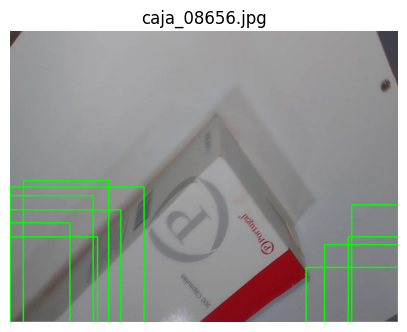


--- Procesando imagen 2/6: caja_08082.jpg
Imagen cargada OK
Tensor enviado a cuda:0
Modelo ejecutado OK
Cantidad propuestas: (55, 4)
Mostrando imagen…


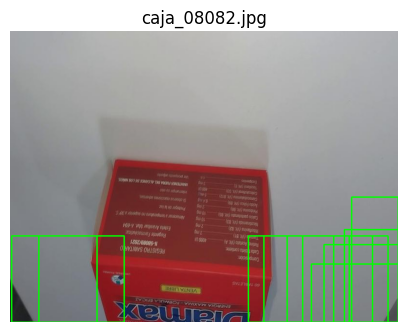


--- Procesando imagen 3/6: jeringa_05745.jpg
Imagen cargada OK
Tensor enviado a cuda:0
Modelo ejecutado OK
Cantidad propuestas: (59, 4)
Mostrando imagen…


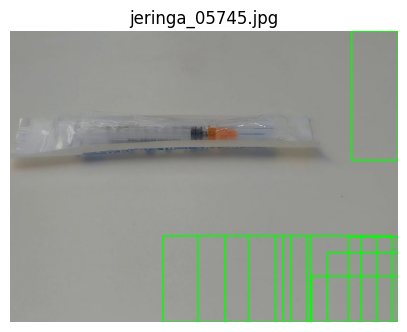


--- Procesando imagen 4/6: caja_04585.jpg
Imagen cargada OK
Tensor enviado a cuda:0
Modelo ejecutado OK
Cantidad propuestas: (57, 4)
Mostrando imagen…


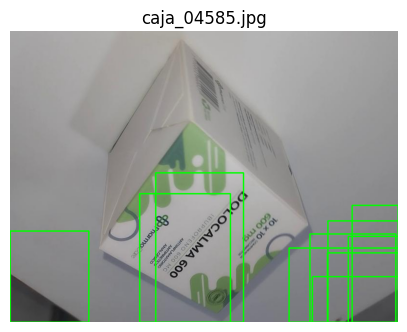


--- Procesando imagen 5/6: jeringa_06582.jpg
Imagen cargada OK
Tensor enviado a cuda:0
Modelo ejecutado OK
Cantidad propuestas: (55, 4)
Mostrando imagen…


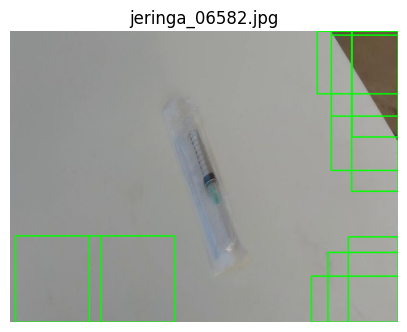


--- Procesando imagen 6/6: jeringa_05304.jpg
Imagen cargada OK
Tensor enviado a cuda:0
Modelo ejecutado OK
Cantidad propuestas: (58, 4)
Mostrando imagen…


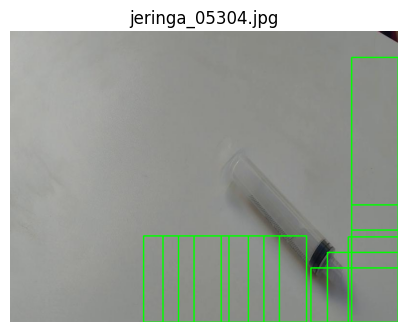


>>> FIN FUNCIÓN mostrar_detecciones_debug


In [42]:
mostrar_detecciones_debug(modelo)

MATRIZ DE CONFUSION
-

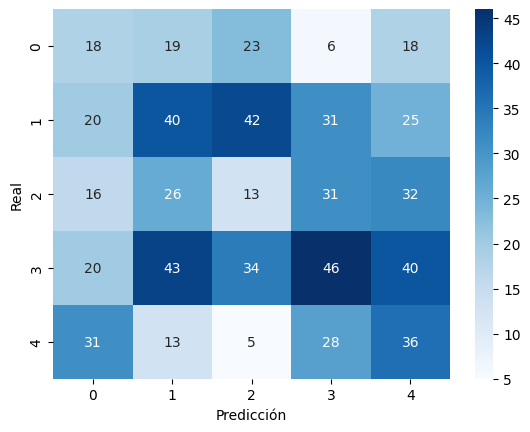

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def matriz_confusion_dummy():
    M = np.random.randint(0,50,(5,5))
    sns.heatmap(M, annot=True, cmap="Blues")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

matriz_confusion_dummy()